In [1]:
# import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import rasterio
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES

import xgrid_utils

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [4]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [5]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [6]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1

In [100]:
# import os

# # Specify the directory to search for files
# directory = 'output/huss_on_tw'

# # Loop through each file in the directory
# for year in range(1981,2021):
#     filename = f'huss_on_warm_season_tw_deciles_{year}.nc'
#     file_path = os.path.join(directory, filename)
#     print(file_path)
#     if os.path.isfile(file_path):
#         os.remove(file_path)
    
    


In [21]:
era5_monthly_tp_trend = []

era5_monthly_tp_r_tx_tw_slope = []
era5_monthly_tp_r_tx_tw_r2 = []
era5_monthly_tp_r_tx_tw_corr = []


for m in range(0, 12):
    
    with open(f'era5_tp_monthly_trend_{m}.dat', 'rb') as f:
        cur_era5_monthly_tp_trend = pickle.load(f)
        if m == 0:
            era5_monthly_tp_trend = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
        era5_monthly_tp_trend[m,:,:] = cur_era5_monthly_tp_trend
    
    with open(f'era5_monthly_tp_r_tx_tw_{m+1}.dat', 'rb') as f:
        cur_era5_monthly_tp_r_tx_tw = pickle.load(f)
        
        if m == 0:
            era5_monthly_tp_r_tx_tw_slope = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
            era5_monthly_tp_r_tx_tw_r2 = np.full([12, cur_era5_monthly_tp_trend.shape[0], cur_era5_monthly_tp_trend.shape[1]], np.nan)
        
        era5_monthly_tp_r_tx_tw_slope[m,:,:] = cur_era5_monthly_tp_r_tx_tw['era5_monthly_tp_r_tx_tw_slope']
        era5_monthly_tp_r_tx_tw_r2[m,:,:] = cur_era5_monthly_tp_r_tx_tw['era5_monthly_tp_r_tx_tw_r2']
    
    

era5_monthly_tp_r_tx_tw_lag_slope = []
era5_monthly_tp_r_tx_tw_lag_r2 = []

for l in range(0,5+1):
    with open(f'era5_monthly_tp_r_tx_tw_lag{l}.dat', 'rb') as f:
        cur_era5_monthly_tp_corr_lag = pickle.load(f)
        
        if l == 0:
            era5_monthly_tp_r_tx_tw_lag_slope = np.full([6, cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[0], cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[1]], np.nan)
            era5_monthly_tp_r_tx_tw_lag_r2 = np.full([6, cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[0], cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope'].shape[1]], np.nan)
            
            era5_monthly_tp_r_tx_tw_corr = cur_era5_monthly_tp_corr_lag['monthly_tp_corr']
        
        era5_monthly_tp_r_tx_tw_lag_slope[l,:,:] = cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_slope']
        era5_monthly_tp_r_tx_tw_lag_r2[l,:,:] = cur_era5_monthly_tp_corr_lag['era5_monthly_tp_r_tx_tw_r2']
        

In [22]:
era5_monthly_tp_r_tx_tw_r2_max = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)
era5_monthly_tp_r_tx_tw_r2_max_ind = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)


for xlat in range(era5_monthly_tp_r_tx_tw_r2.shape[1]):
    for ylon in range(era5_monthly_tp_r_tx_tw_r2.shape[2]):
        cur = era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon]
        if np.where(~np.isnan(cur))[0].size > 10:
            era5_monthly_tp_r_tx_tw_r2_max[xlat, ylon] = np.nanmax(era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon])
            era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon] = np.nanargmax(era5_monthly_tp_r_tx_tw_r2[:, xlat, ylon])



In [23]:
# extract monthly precip trends for month with max r2 at each grid cell

era5_monthly_tp_trend_max_r2 = np.full([era5_monthly_tp_r_tx_tw_r2.shape[1], era5_monthly_tp_r_tx_tw_r2.shape[2]], np.nan)

for xlat in range(era5_monthly_tp_r_tx_tw_r2_max_ind.shape[0]):
    for ylon in range(era5_monthly_tp_r_tx_tw_r2_max_ind.shape[1]):
        if ~np.isnan(era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon]):
            era5_monthly_tp_trend_max_r2[xlat, ylon] = era5_monthly_tp_trend[int(era5_monthly_tp_r_tx_tw_r2_max_ind[xlat, ylon]), xlat, ylon]*10*1000

In [24]:
era5_monthly_tp = []
for y in range(1981, 2019+1):
    cur_ds_era5_tp = xr.open_mfdataset(f'era5_tp_monthly_{y}.nc')
    era5_monthly_tp.append(cur_ds_era5_tp)

ds_era5_monthly_tp = xr.concat(era5_monthly_tp, dim='time')
ds_era5_monthly_tp.load();

In [25]:
recalc = False

In [26]:


from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tx_on_tw_full = xr.open_mfdataset('output/tasmax_on_tw/tasmax_on_tww*.nc', combine='nested', concat_dim='time')
    tx_on_tw_full = tx_on_tw_full.where(land_sea_mask_binary)
    tx_on_tw_full = tx_on_tw_full.rename({'__xarray_dataarray_variable__':'tx_on_tww'})
    tx_on_tw_full['tx_on_tww'] -= 273.15
    tx_on_tw_full = tx_on_tw_full.sel(latitude=slice(60,-60))
    tx_on_tw_full.load()

    tx_on_tw_full.to_netcdf('intermediate/tx_on_tw_full.nc')

else:
    tx_on_tw_full = xr.open_dataset('intermediate/tx_on_tw_full.nc')
    
tx_on_tw_mean = tx_on_tw_full.mean(dim='time')
tx_on_tw_ts = xgrid_utils.calc_spatial_mean(tx_on_tw_full)
# tx_on_tw_ts.to_netcdf('intermediate/tx_on_tw_ts.nc')


In [27]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tw_on_tx_full = xr.open_mfdataset('output/tw_max_on_tx/tw_max_on_txx*.nc', combine='nested', concat_dim='time')
    tw_on_tx_full = tw_on_tx_full.where(land_sea_mask_binary)
    tw_on_tx_full = tw_on_tx_full.rename({'__xarray_dataarray_variable__':'tw_on_txx'})
    tw_on_tx_full = tw_on_tx_full.sel(latitude=slice(60,-60))
    tw_on_tx_full.load()

    tw_on_tx_full.to_netcdf('intermediate/tw_on_tx_full.nc')
else:
    tw_on_tx_full = xr.open_dataset('intermediate/tw_on_tx_full.nc')

# tw_on_tx_full['tw'][-1,:,:,:] += 273.15
    
tw_on_tx_mean = tw_on_tx_full.mean(dim='time')
tw_on_tx_ts = xgrid_utils.calc_spatial_mean(tw_on_tx_full)
# tw_on_tx_ts.to_netcdf('intermediate/tw_on_tx_ts.nc')


In [28]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tx_on_tx_full = xr.open_mfdataset('output/tasmax_on_tx/tasmax_on_txx*.nc', combine='nested', concat_dim='time')
    tx_on_tx_full = tx_on_tx_full.where(land_sea_mask_binary)
    tx_on_tx_full = tx_on_tx_full.rename({'__xarray_dataarray_variable__':'tx_on_txx'})
    tx_on_tx_full['tx_on_txx'] -= 273.15
    tx_on_tx_full = tx_on_tx_full.sel(latitude=slice(60,-60))
    tx_on_tx_full.load()

    tx_on_tx_full.to_netcdf('intermediate/tx_on_tx_full.nc')

else:
    tx_on_tx_full = xr.open_dataset('intermediate/tx_on_tx_full.nc')

tx_on_tx_ts = xgrid_utils.calc_spatial_mean(tx_on_tx_full)
tx_on_tx_mean = tx_on_tx_full.mean(dim='time')
# tx_on_tx_ts.to_netcdf('intermediate/tx_on_tx_ts.nc')



In [29]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    tw_on_tw_full = xr.open_mfdataset('output/tw_max_on_tw/tw_max_on_tww*.nc', combine='nested', concat_dim='time')
    tw_on_tw_full = tw_on_tw_full.where(land_sea_mask_binary)
    tw_on_tw_full = tw_on_tw_full.rename({'__xarray_dataarray_variable__':'tw_on_tww'})
    tw_on_tw_full = tw_on_tw_full.sel(latitude=slice(60,-60))
    tw_on_tw_full.load()

    tw_on_tw_full.to_netcdf('intermediate/tw_on_tw_full.nc')
else:
    tw_on_tw_full = xr.open_dataset('intermediate/tw_on_tw_full.nc')

tw_on_tw_ts = xgrid_utils.calc_spatial_mean(tw_on_tw_full)
tw_on_tw_mean = tw_on_tw_full.mean(dim='time')
# tw_on_tw_ts.to_netcdf('intermediate/tw_on_tw_ts.nc')




In [30]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    huss_on_txx_full = xr.open_mfdataset('output/huss_on_tx/huss_on_txx_*.nc', combine='nested', concat_dim='time')
    huss_on_txx_full = huss_on_txx_full.where(land_sea_mask_binary)
    huss_on_txx_full = huss_on_txx_full.sel(latitude=slice(60,-60))
    huss_on_txx_full = huss_on_txx_full.rename({'__xarray_dataarray_variable__':'huss_on_txx'})
    huss_on_txx_full.load()

    huss_on_txx_full.to_netcdf('intermediate/huss_on_txx.nc')
else:
    huss_on_txx_full = xr.open_dataset('intermediate/huss_on_txx.nc')

huss_on_txx_ts = xgrid_utils.calc_spatial_mean(huss_on_txx_full)

if recalc:
    huss_on_txx_ts.to_netcdf('intermediate/huss_on_txx_ts.nc')



In [31]:
from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

if recalc:
    time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
    huss_on_tww_full = xr.open_mfdataset('output/huss_on_tw/huss_on_tww_*.nc', combine='nested', concat_dim='time')
    huss_on_tww_full = huss_on_tww_full.where(land_sea_mask_binary)
    huss_on_tww_full = huss_on_tww_full.sel(latitude=slice(60,-60))
    huss_on_tww_full = huss_on_tww_full.rename({'__xarray_dataarray_variable__':'huss_on_tww'})
    huss_on_tww_full.load()

    huss_on_tww_full.to_netcdf('intermediate/huss_on_tww.nc')
else:
    huss_on_tww_full = xr.open_dataset('intermediate/huss_on_tww.nc')

huss_on_tww_ts = xgrid_utils.calc_spatial_mean(huss_on_tww_full)

if recalc:
    huss_on_tww_ts.to_netcdf('intermediate/huss_on_tww_ts.nc')



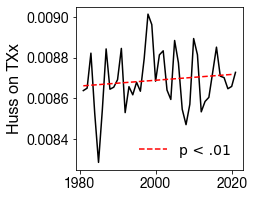

In [23]:
x_var = np.arange(1981,2022)
y_var = huss_on_txx_ts.huss_on_txx.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('Huss on TXx')
# plt.yticks([-3.5, -3.4, -3.3, -3.2, -3.1])
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tx|tww-txx-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

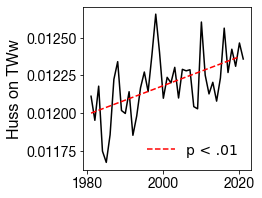

In [22]:
x_var = np.arange(1981,2022)
y_var = huss_on_tww_ts.huss_on_tww.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('Huss on TWw')
# plt.yticks([-3.5, -3.4, -3.3, -3.2, -3.1])
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tx|tww-txx-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


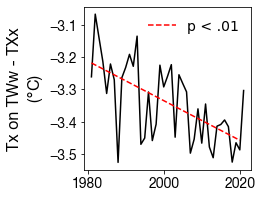

In [24]:
x_var = np.arange(1981,2022)
# y_var = (tx_on_tw_ts.mx2t[:,-1].values - tx_on_tx_ts.mx2t[:,-1].values)
y_var = (tx_on_tw_ts.tx_on_tww.values - tx_on_tx_ts.tx_on_txx.values)

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('Tx on TWw - TXx\n($\degree$C)')
plt.yticks([-3.5, -3.4, -3.3, -3.2, -3.1])
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tx|tww-txx-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

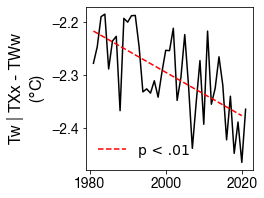

In [111]:
x_var = np.arange(1981,2022)
y_var = (tw_on_tx_ts.tw_on_txx.values - tw_on_tw_ts.tw_on_tww.values)

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('Tw | TXx - TWw\n($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('tw|tx-tww-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [32]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_huss_corr_full = xr.open_mfdataset('output/tx_huss_corr/tx_huss_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_huss_corr_full['time'] = time_dim
tx_huss_corr_full = tx_huss_corr_full.rename({'__xarray_dataarray_variable__':'tx_huss_corr'})
tx_huss_corr_full = tx_huss_corr_full.where(land_sea_mask_binary)
tx_huss_corr_full = tx_huss_corr_full.sel(latitude=slice(60,-60))
tx_huss_corr_full.load()
# tx_huss_corr_full.to_netcdf('intermediate/tx_huss_corr_full.nc')


tx_huss_corr_mean = tx_huss_corr_full.mean(dim='time')
tx_huss_corr_ts = xgrid_utils.calc_spatial_mean(tx_huss_corr_full)

# tx_huss_corr_ts = tx_huss_corr_full.mean(dim=['latitude', 'longitude'])

# tx_huss_corr_mean.to_netcdf('intermediate/tx_huss_corr_mean.nc')
# tx_huss_corr_ts.to_netcdf('intermediate/tx_huss_corr_ts.nc')

In [33]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)

tx_tw_corr_full = tx_tw_corr_full.sel(latitude=slice(60,-60))
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')
tx_tw_corr_ts = xgrid_utils.calc_spatial_mean(tx_tw_corr_full)
# tx_tw_corr_ts.to_netcdf('intermediate/tx_tw_corr_ts.nc')
# tx_tw_corr_full.to_netcdf('intermediate/tx_tw_corr.nc')





In [34]:


with open('era5_huss_on_txx_per_rtet.dat', 'rb') as f:
    era5_huss_on_txx_per_rtet = pickle.load(f)
with open('era5_huss_on_tww_per_rtet.dat', 'rb') as f:
    era5_huss_on_tww_per_rtet = pickle.load(f)

with open('era5_tw_on_txx_per_rtet_int.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet_int = pickle.load(f)
with open('era5_tw_on_txx_per_rtet.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet = pickle.load(f)
with open('era5_tw_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet_r2 = pickle.load(f)

with open('era5_tw_on_txx_minus_tw_on_tww_per_rtet.dat', 'rb') as f:
    era5_tw_on_txx_minus_tw_on_tww_per_rtet = pickle.load(f)
with open('era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2 = pickle.load(f)
    
with open('era5_tx_on_txx_per_rtet_int.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet_int = pickle.load(f)
with open('era5_tx_on_txx_per_rtet.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet = pickle.load(f)
with open('era5_tx_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet_r2 = pickle.load(f)
    
with open('era5_tw_on_tww_per_rtet_int.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet_int = pickle.load(f)
with open('era5_tw_on_tww_per_rtet.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet = pickle.load(f)
with open('era5_tw_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet_r2 = pickle.load(f)

with open('era5_tx_on_tww_per_rtet_int.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet_int = pickle.load(f)
with open('era5_tx_on_tww_per_rtet.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet = pickle.load(f)
with open('era5_tx_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet_r2 = pickle.load(f)
    
with open('era5_tx_on_tww_minus_tx_on_txx_per_rtet.dat', 'rb') as f:
    era5_tx_on_tww_minus_tx_on_txx_per_rtet = pickle.load(f)
with open('era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2 = pickle.load(f)
    
    
era5_huss_on_txx_per_rtet_da = xr.DataArray(
    era5_huss_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)


era5_huss_on_tww_per_rtet_da = xr.DataArray(
    era5_huss_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude.values,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude.values  # Coordinate for longitude
    }
)


    

# TW ON TWW
era5_tw_on_tww_per_rtet_da = xr.DataArray(
    era5_tw_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


era5_tw_on_tww_per_rtet_int_da = xr.DataArray(
    era5_tw_on_tww_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


era5_tw_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TW ON TXX MINUS TW ON TWW
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da = xr.DataArray(
    era5_tw_on_txx_minus_tw_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TX ON TWW MINUS TX ON TXX
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da = xr.DataArray(
    era5_tx_on_tww_minus_tx_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TW ON TXX
era5_tw_on_txx_per_rtet_da = xr.DataArray(
    era5_tw_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tw_on_txx_per_rtet_int_da = xr.DataArray(
    era5_tw_on_txx_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tw_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TX ON TXX
era5_tx_on_txx_per_rtet_da = xr.DataArray(
    era5_tx_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_txx_per_rtet_int_da = xr.DataArray(
    era5_tx_on_txx_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


# TX ON TWW
era5_tx_on_tww_per_rtet_da = xr.DataArray(
    era5_tx_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)

era5_tx_on_tww_per_rtet_int_da = xr.DataArray(
    era5_tx_on_tww_per_rtet_int,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)


era5_tx_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': tx_tw_corr_full.latitude,  # Coordinate for latitude
        'longitude': tx_tw_corr_full.longitude  # Coordinate for longitude
    }
)
    

In [35]:
# load bootstrapped trends
era5_r_tx_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tw_on_tx_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
era5_r_tx_tw_vs_tx_on_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)

lat_skip = 20
for d in range(24):
    with open(f'era5_r_tx_tw_slope_bootstrap_100_decile{d}_2_26_4pm.dat', 'rb') as f:
        cur_era5_r_tx_tw_slice = pickle.load(f)
        era5_r_tx_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_slope'][0:20,:,:]
        era5_r_tx_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_int'][0:20,:,:]

        era5_r_tx_tw_vs_tw_on_tx_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tw_on_tx_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_int'][0:20,:,:]

        era5_r_tx_tw_vs_tx_on_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_slope'][0:20,:,:]
        era5_r_tx_tw_vs_tx_on_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_int'][0:20,:,:]

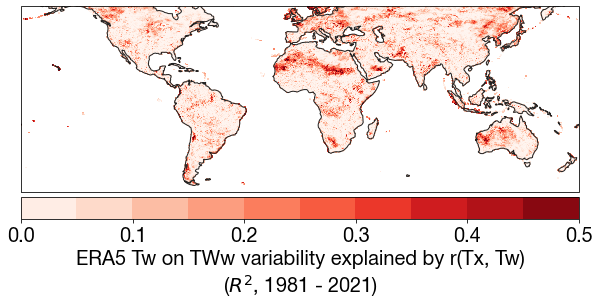

In [275]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = 0
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = era5_tw_on_tww_per_rtet_r2_da

c = plt.pcolormesh(era5_tx_on_txx_per_rtet_r2_da.longitude, era5_tx_on_tww_per_rtet_r2_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('ERA5 Tw on TWw variability explained by r(Tx, Tw)\n($R^2$, 1981 - 2021)', fontsize=20)

# plt.savefig('era5-tx-on-txx-from-rtet-r2-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

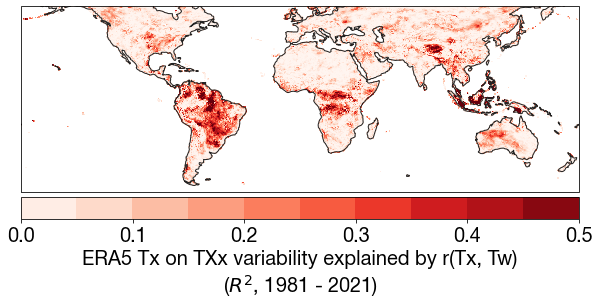

In [276]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = 0
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = era5_tx_on_txx_per_rtet_r2_da

c = plt.pcolormesh(era5_tx_on_txx_per_rtet_r2_da.longitude, era5_tx_on_tww_per_rtet_r2_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('ERA5 Tx on TXx variability explained by r(Tx, Tw)\n($R^2$, 1981 - 2021)', fontsize=20)

# plt.savefig('era5-tx-on-txx-from-rtet-r2-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

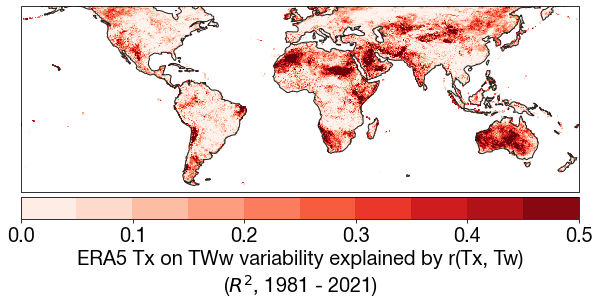

In [277]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = 0
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = era5_tx_on_tww_per_rtet_r2_da

c = plt.pcolormesh(era5_tx_on_txx_per_rtet_r2_da.longitude, era5_tx_on_tww_per_rtet_r2_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('ERA5 Tx on TWw variability explained by r(Tx, Tw)\n($R^2$, 1981 - 2021)', fontsize=20)

# plt.savefig('era5-tx-on-txx-from-rtet-r2-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

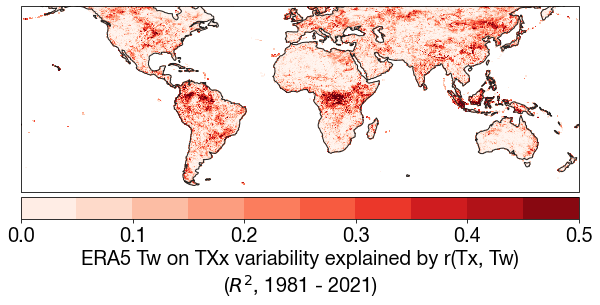

In [278]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = 0
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = era5_tw_on_txx_per_rtet_r2_da

c = plt.pcolormesh(era5_tx_on_tww_per_rtet_r2_da.longitude, era5_tx_on_tww_per_rtet_r2_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('ERA5 Tw on TXx variability explained by r(Tx, Tw)\n($R^2$, 1981 - 2021)', fontsize=20)

# plt.savefig('era5-tx-on-txx-from-rtet-r2-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [36]:
era5_r_tx_tw_slope = np.moveaxis(era5_r_tx_tw_slope, 2, 0)
era5_r_tx_tw_int = np.moveaxis(era5_r_tx_tw_int, 2, 0)

era5_r_tx_tw_vs_tw_on_tx_slope = np.moveaxis(era5_r_tx_tw_vs_tw_on_tx_slope, 2, 0)
era5_r_tx_tw_vs_tw_on_tx_int = np.moveaxis(era5_r_tx_tw_vs_tw_on_tx_int, 2, 0)

era5_r_tx_tw_vs_tx_on_tw_slope = np.moveaxis(era5_r_tx_tw_vs_tx_on_tw_slope, 2, 0)
era5_r_tx_tw_vs_tx_on_tw_int = np.moveaxis(era5_r_tx_tw_vs_tx_on_tw_int, 2, 0)

In [37]:
era5_r_tx_tw_slope_da = xr.DataArray(
    data=era5_r_tx_tw_slope,  # Use your data array here
    dims=["bootstrap", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "bootstrap":np.arange(0,100),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

era5_r_tx_tw_slope_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_slope_da)

era5_r_tx_tw_int_da = xr.DataArray(
    data=era5_r_tx_tw_int,  # Use your data array here
    dims=["bootstrap", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "bootstrap":np.arange(0,100),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

era5_r_tx_tw_int_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_int_da)

Object `plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')` not found.


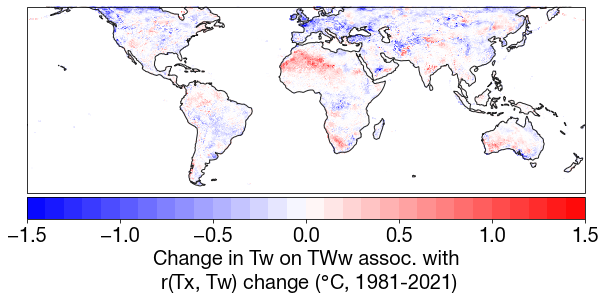

In [137]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (era5_tw_on_tww_per_rtet_da * (np.nanmean(era5_r_tx_tw_slope, axis=0)*(2021-1981+1)))

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tw on TWw assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tw_on_tx_from_r_tx_tw_chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

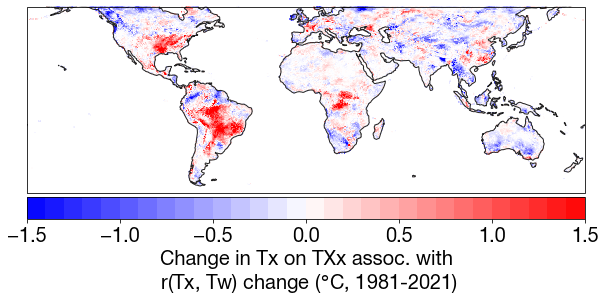

In [269]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (era5_tx_on_txx_per_rtet_da * (np.nanmean(era5_r_tx_tw_slope, axis=0)*(2021-1981+1)))

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tx on TXx assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tw_on_tx_from_r_tx_tw_chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

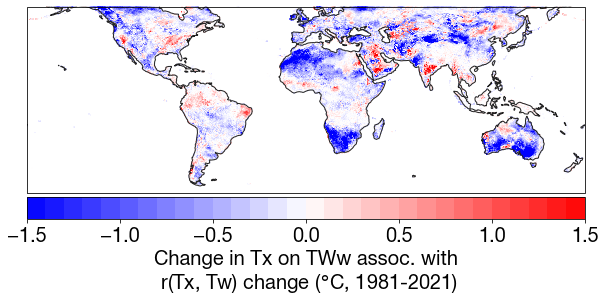

In [95]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (era5_tx_on_tww_per_rtet_da * (np.nanmean(era5_r_tx_tw_slope, axis=0)*(2021-1981+1)))

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# ?plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tx on TWw assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tw_on_tx_from_r_tx_tw_chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Object `plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')` not found.


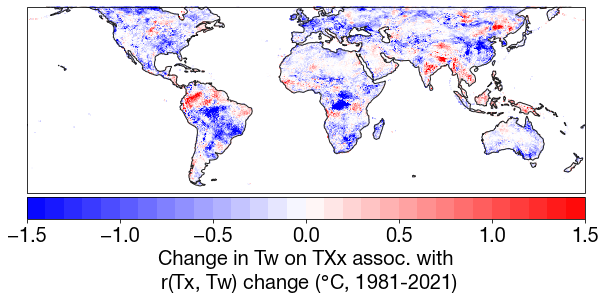

In [271]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (era5_tw_on_txx_per_rtet_da * (np.nanmean(era5_r_tx_tw_slope, axis=0)*(2021-1981+1)))

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

?plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tw on TXx assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

# plt.savefig('tw_on_tx_from_r_tx_tw_chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

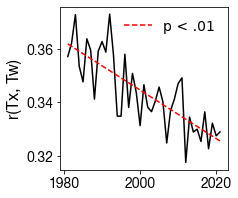

In [20]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_tw_corr_ts.tx_tw_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))

# for b in range(era5_r_tx_tw_slope_spatial_mean.bootstrap.size):
#     plt.plot([x1, x2], [era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*0, era5_r_tx_tw_int_spatial_mean.values[b]+era5_r_tx_tw_slope_spatial_mean[b]*(x2-x1)], '-', c='#aaaaaa')
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Tw)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,tw)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [117]:


lat_ranges_step = -5
lat_ranges = np.arange(60, -60, lat_ranges_step)

tx_tw_corr_trend_lat_ranges = np.full(lat_ranges.size, np.nan)
tx_tw_corr_pval_lat_ranges = np.full(lat_ranges.size, np.nan)

huss_sm_corr_trend_lat_ranges = np.full(lat_ranges.size, np.nan)
huss_sm_corr_pval_lat_ranges = np.full(lat_ranges.size, np.nan)

for l in range(lat_ranges.size-1):
    l1 = lat_ranges[l]
    l2 = lat_ranges[l+1]
    
    tx_tw_corr_cur = tx_tw_corr_full.tx_tw_corr.sel(latitude=slice(l1,l2)).mean(dim=['latitude', 'longitude'])
#     huss_sm_corr_cur = huss_sm_corr_full.huss_sm_corr.sel(latitude=slice(l1,l2)).mean(dim=['latitude', 'longitude'])
    
    nn = np.where((~np.isnan(tx_tw_corr_cur.values)))[0]
    if nn.size > 0:
        X = sm.add_constant(range(nn.size))
        mdl = sm.OLS(tx_tw_corr_cur.values[nn], X).fit()

        tx_tw_corr_trend_lat_ranges[l] = mdl.params[1]*10
        tx_tw_corr_pval_lat_ranges[l] = mdl.pvalues[1]
        
#     nn = np.where((~np.isnan(huss_sm_corr_cur.values)))[0]
#     if nn.size > 0:
#         X = sm.add_constant(range(nn.size))
#         mdl = sm.OLS(huss_sm_corr_cur.values[nn], X).fit()

#         huss_sm_corr_trend_lat_ranges[l] = mdl.params[1]*10
#         huss_sm_corr_pval_lat_ranges[l] = mdl.pvalues[1]




Text(0.5, 0, 'r(Tx, Tw) trend\n(per decade)')

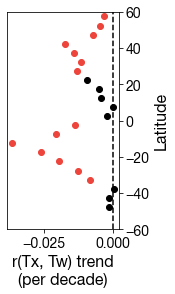

In [118]:
plt.figure(figsize=(2,4))
plt.ylim([-60,60])

# Calculate indexes where p value is less than .05
idx = tx_tw_corr_pval_lat_ranges < .05

# Plot data where p value is less than .05 in black
plt.plot(tx_tw_corr_trend_lat_ranges[idx], lat_ranges[idx]-lat_ranges_step/2, 'o', color='#ed443b')

# Plot data where p value is greater than or equal to .05 in red
plt.plot(tx_tw_corr_trend_lat_ranges[~idx], lat_ranges[~idx]-lat_ranges_step/2, 'o', color='k')


plt.plot([0,0], [-60, 60], '--k')
# plt.yticks([])
plt.ylabel('Latitude')
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

# plt.xticks([-60,-30,0,30,60])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
# plt.savefig('r(tx,tw)-trend-by-lat.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

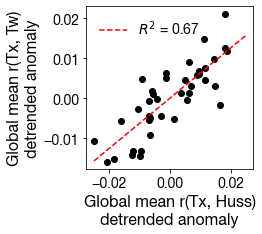

In [119]:
plt.figure(figsize=(3,3))

x_var = signal.detrend(tx_huss_corr_ts.tx_huss_corr.values)
y_var = signal.detrend(tx_tw_corr_ts.tx_tw_corr.values[0:-1])

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.025
x2 = 0.025

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ = %.2f'%mdl.rsquared)
plt.xlabel('Global mean r(Tx, Huss)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean r(Tx, Tw)\ndetrended anomaly')
font = FontProperties(size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-r(tx,huss).png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

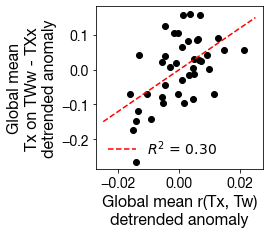

In [82]:

plt.figure(figsize=(3,3))

x_var = signal.detrend(tx_tw_corr_ts.tx_tw_corr.values)
# x_var = signal.detrend(tx_huss_corr_ts.tx_huss_corr.values)
y_var = signal.detrend((tx_on_tw_ts.tx_on_tww.values - tx_on_tx_ts.tx_on_txx.values))
# y_var = signal.detrend((tw_on_tx_ts.tw[:,-1].values - tw_on_tw_ts.tw[:,-1].values)-273.15)
# y_var = signal.detrend(tw_on_tx_ts.tw[:,-1].values)

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.025
x2 = 0.025

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ = %.2f'%mdl.rsquared)
plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTx on TWw - TXx\ndetrended anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-tx|tw100-tx100.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


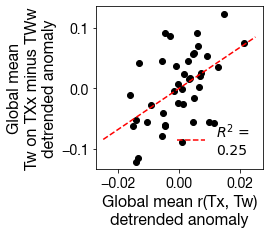

In [121]:

plt.figure(figsize=(3,3))

x_var = signal.detrend(tx_tw_corr_ts.tx_tw_corr.values)
# x_var = signal.detrend(tx_huss_corr_ts.tx_huss_corr.values)
y_var = signal.detrend((tw_on_tx_ts.tw_on_txx.values - tw_on_tw_ts.tw_on_tww.values))

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.025
x2 = 0.025

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ =\n%.2f'%mdl.rsquared)
plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTw on TXx minus TWw\ndetrended anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font, loc='lower right')

# plt.savefig('r(tx,tw)-tw|tx100-tw100.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [38]:
lsm = land_sea_mask_binary.sel(latitude=slice(60,-60))

In [39]:
tw_on_txx_from_rtet_da = era5_tw_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tx_on_tww_from_rtet_da = era5_tx_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tw_on_tww_from_rtet_da = era5_tw_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tx_on_txx_from_rtet_da = era5_tx_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

huss_on_tww_from_rtet_da = era5_huss_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
huss_on_txx_from_rtet_da = era5_huss_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

tx_on_tww_minus_tx_on_txx_from_rtet_da = era5_tx_on_tww_minus_tx_on_txx_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))
tw_on_txx_minus_tw_on_tww_from_rtet_da = era5_tw_on_txx_minus_tw_on_tww_per_rtet_da * (tx_tw_corr_full.tx_tw_corr - np.nanmean(tx_tw_corr_full.tx_tw_corr, axis=0))

In [40]:
huss_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(huss_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

huss_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(huss_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tw_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tx_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tw_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tx_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_tww_minus_tx_on_txx_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tx_on_tww_minus_tx_on_txx_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_txx_minus_tw_on_tww_from_rtet_da = xr.DataArray(
    data=np.moveaxis(tw_on_txx_minus_tw_on_tww_from_rtet_da.values,2,0),  # Use your data array here
    dims=["time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "time":np.arange(1981,2022),
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)


# huss_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(huss_on_txx_from_rtet_da)
# huss_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(huss_on_tww_from_rtet_da)
tw_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_from_rtet_da)
tx_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_from_rtet_da)
tw_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_tww_from_rtet_da)
tx_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_txx_from_rtet_da)

tx_on_tww_minus_tx_on_txx_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_minus_tx_on_txx_from_rtet_da)
tw_on_txx_minus_tw_on_tww_from_rtet_da_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_minus_tw_on_tww_from_rtet_da)

In [43]:
recalc = False

if recalc:
    huss_on_txx_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    huss_on_tww_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    
    tw_on_txx_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tx_on_tww_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tx_on_txx_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)
    tw_on_tww_chg_from_rtet = np.full([tw_on_tx_full.tw_on_txx.latitude.size, tw_on_tx_full.tw_on_txx.longitude.size], np.nan)

    for xlat in range(tx_tw_corr_full.tx_tw_corr.latitude.size):
        if xlat%25==0:print(xlat)
        for ylon in range(tx_tw_corr_full.tx_tw_corr.longitude.size):
            if lsm[xlat, ylon]:
                ts = huss_on_txx_from_rtet_da[:, xlat, ylon].values
                X = sm.add_constant(np.arange(ts.size))
                mdl = sm.OLS(ts,X).fit()
                huss_on_txx_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size

                ts = huss_on_tww_from_rtet_da[:, xlat, ylon].values
                X = sm.add_constant(np.arange(ts.size))
                mdl = sm.OLS(ts,X).fit()
                huss_on_tww_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
                
                ts = tw_on_txx_from_rtet_da[:, xlat, ylon].values
                X = sm.add_constant(np.arange(ts.size))
                mdl = sm.OLS(ts,X).fit()
                tw_on_txx_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size

                ts = tx_on_tww_from_rtet_da[:, xlat, ylon].values
                X = sm.add_constant(np.arange(ts.size))
                mdl = sm.OLS(ts,X).fit()
                tx_on_tww_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size

                ts = tx_on_txx_from_rtet_da[:, xlat, ylon].values
                X = sm.add_constant(np.arange(ts.size))
                mdl = sm.OLS(ts,X).fit()
                tx_on_txx_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size

                ts = tw_on_tww_from_rtet_da[:, xlat, ylon].values
                X = sm.add_constant(np.arange(ts.size))
                mdl = sm.OLS(ts,X).fit()
                tw_on_tww_chg_from_rtet[xlat, ylon] = mdl.params[1]*ts.size
                
    with open('huss_on_txx_chg_from_rtet.dat', 'wb') as f:
        pickle.dump(huss_on_txx_chg_from_rtet, f)
    with open('huss_on_tww_chg_from_rtet.dat', 'wb') as f:
        pickle.dump(huss_on_tww_chg_from_rtet, f)
    with open('tw_on_txx_chg_from_rtet.dat', 'wb') as f:
        pickle.dump(tw_on_txx_chg_from_rtet, f)
    with open('tx_on_tww_chg_from_rtet.dat', 'wb') as f:
        pickle.dump(tx_on_tww_chg_from_rtet, f)
    with open('tx_on_txx_chg_from_rtet.dat', 'wb') as f:
        pickle.dump(tx_on_txx_chg_from_rtet, f)
    with open('tw_on_tww_chg_from_rtet.dat', 'wb') as f:
        pickle.dump(tw_on_tww_chg_from_rtet, f)
else:
    with open('huss_on_txx_chg_from_rtet.dat', 'rb') as f:
        huss_on_txx_chg_from_rtet = pickle.load(f)
    with open('huss_on_tww_chg_from_rtet.dat', 'rb') as f:
        huss_on_tww_chg_from_rtet = pickle.load(f)
    with open('tw_on_txx_chg_from_rtet.dat', 'rb') as f:
        tw_on_txx_chg_from_rtet = pickle.load(f)
    with open('tx_on_tww_chg_from_rtet.dat', 'rb') as f:
        tx_on_tww_chg_from_rtet = pickle.load(f)
    with open('tx_on_txx_chg_from_rtet.dat', 'rb') as f:
        tx_on_txx_chg_from_rtet = pickle.load(f)
    with open('tw_on_tww_chg_from_rtet.dat', 'rb') as f:
        tw_on_tww_chg_from_rtet = pickle.load(f)
    

In [44]:
huss_on_txx_chg_from_rtet_da = xr.DataArray(
    data=huss_on_txx_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

huss_on_tww_chg_from_rtet_da = xr.DataArray(
    data=huss_on_tww_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_txx_chg_from_rtet_da = xr.DataArray(
    data=tw_on_txx_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_tww_chg_from_rtet_da = xr.DataArray(
    data=tx_on_tww_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tx_on_txx_chg_from_rtet_da = xr.DataArray(
    data=tx_on_txx_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)

tw_on_tww_chg_from_rtet_da = xr.DataArray(
    data=tw_on_tww_chg_from_rtet,  # Use your data array here
    dims=["latitude", "longitude"],  # Specify the dimensions names
    coords={
        "latitude": tx_tw_corr_full.latitude.values,  # Latitude coordinates
        "longitude": tx_tw_corr_full.longitude.values  # Longitude coordinates
    }
)




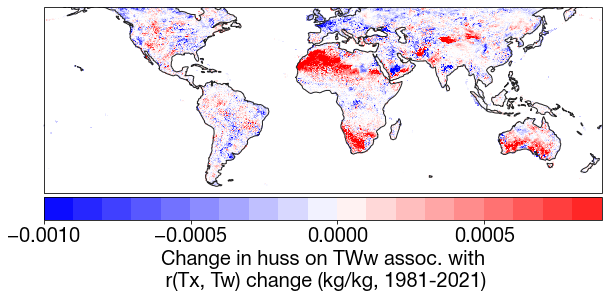

In [45]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.001
v2 = .001
vstep = .0001
vlabelstep = .0005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = huss_on_tww_chg_from_rtet_da

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in huss on TWw assoc. with\n r(Tx, Tw) change (kg/kg, 1981-2021)', fontsize=20)

# plt.savefig('huss_on_tww_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


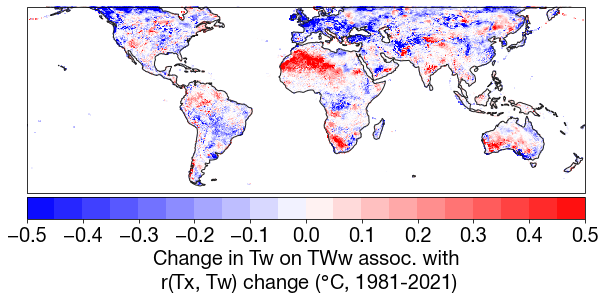

In [56]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tw_on_tww_chg_from_rtet_da

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tw on TWw assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

plt.savefig('tw_on_tww_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


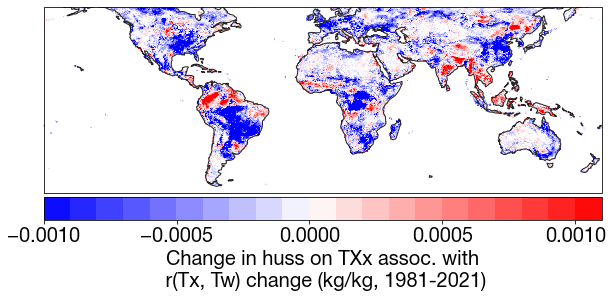

In [53]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.001
v2 = .0011
vstep = .0001
vlabelstep = .0005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = huss_on_txx_chg_from_rtet_da

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in huss on TXx assoc. with\n r(Tx, Tw) change (kg/kg, 1981-2021)', fontsize=20)

plt.savefig('huss_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


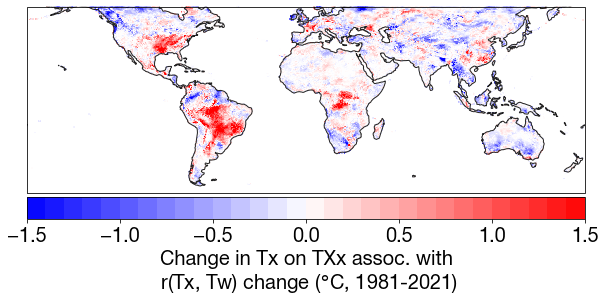

In [55]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tx_on_txx_chg_from_rtet_da

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tx on TXx assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

plt.savefig('tx_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


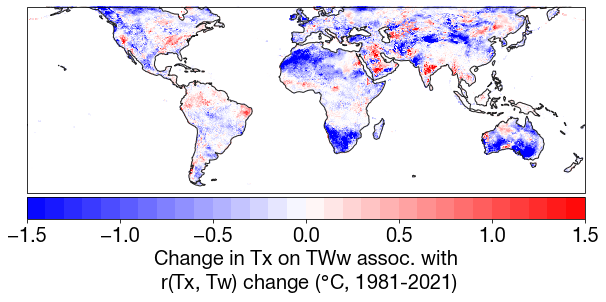

In [70]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tx_on_tww_chg_from_rtet_da

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tx on TWw assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

plt.savefig('tx_on_tww_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


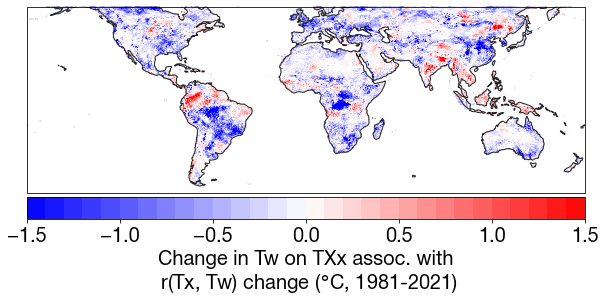

In [489]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tw_on_txx_chg_from_rtet_da

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tw on TXx assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

plt.savefig('tw_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


NameError: name 'tw_on_tww_chg_from_rtet_da' is not defined

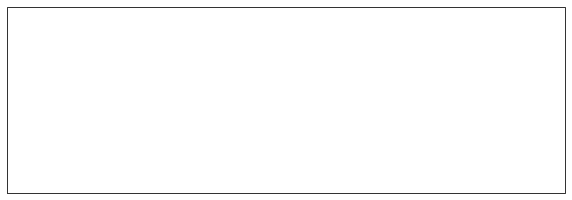

In [48]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = tw_on_tww_chg_from_rtet_da

c = plt.pcolormesh(tx_tw_corr_full.longitude, tx_tw_corr_full.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.2f$\degree$C'%(tx_on_tw100_chg_from_r_tx_tw_spatial_mean.mean().values), fontdict={'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in Tw on TXx assoc. with\n r(Tx, Tw) change ($\degree$C, 1981-2021)', fontsize=20)

plt.savefig('tw_on_txx_chg_from_rtet-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [493]:
(mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)) - (mdl.params[0]+mdl.params[1]*x2)

0.16613734569878602

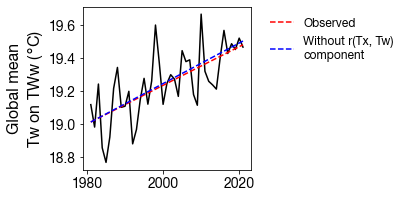

In [135]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(tw_on_tw_full.tw_on_tww).values
y_var2 = xgrid_utils.calc_spatial_mean(tw_on_tw_full.tw_on_tww - tw_on_tww_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nTw on TWw ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('tw_on_tww_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

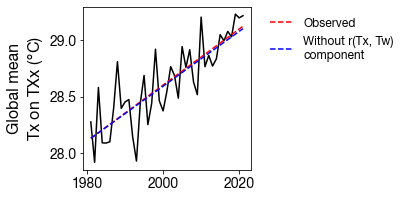

In [134]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(tx_on_tx_full.tx_on_txx).values
y_var2 = xgrid_utils.calc_spatial_mean(tx_on_tx_full.tx_on_txx - tx_on_txx_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nTx on TXx ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('tx_on_txx_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

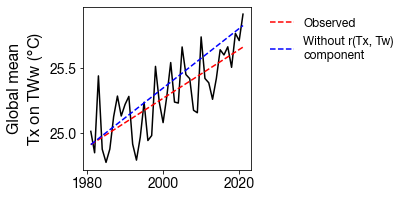

In [133]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(tx_on_tw_full.tx_on_tww).values
y_var2 = xgrid_utils.calc_spatial_mean(tx_on_tw_full.tx_on_tww - tx_on_tww_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nTx on TWw ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('tx_on_tww_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

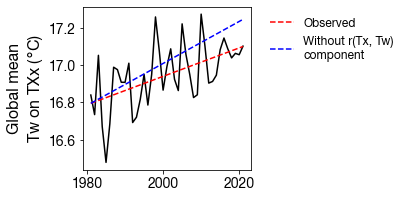

In [132]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = xgrid_utils.calc_spatial_mean(tw_on_tx_full.tw_on_txx).values
y_var2 = xgrid_utils.calc_spatial_mean(tw_on_tx_full.tw_on_txx - tw_on_txx_from_rtet_da).values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()


nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var2)))[0]
X = sm.add_constant(x_var[nn])
mdl2 = sm.OLS(y_var2[nn], X).fit()

x1 = 1981
x2 = 2021

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='Observed')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x1 + mdl2.params[1]*(x2-x1)], '--b', label='Without r(Tx, Tw)\ncomponent')
plt.ylabel('Global mean\nTw on TXx ($\degree$C)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('tw_on_txx_from_rtxtw-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

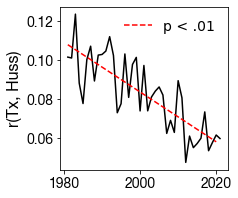

In [324]:
x_var = tx_huss_corr_ts.tx_huss_corr.time.dt.year.values
y_var = tx_huss_corr_ts.tx_huss_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Huss)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,huss)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

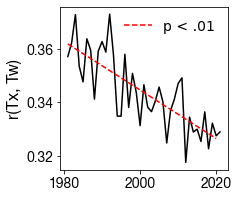

In [12]:
x_var = tx_tw_corr_ts.tx_tw_corr.time.dt.year.values
y_var = tx_tw_corr_ts.tx_tw_corr.values

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = 1981
x2 = 2020

plt.figure(figsize=(3,3))
plt.plot(x_var, y_var, '-k')
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--r', label='p < .01')
plt.ylabel('r(Tx, Tw)')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
# plt.savefig('r(tx,tw)-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [178]:
#CALC ERA5 GLOBAL MEAN TX TIME SERIES
recalc = False
if recalc:
    tx_era5 = xr.open_mfdataset('%s/daily/tasmax_*.nc'%dirEra5)
    tx_era5 = tx_era5.sel(time=slice('1981', '2021')).sel(latitude=slice(60, -60))
    tx_era5['mx2t'] -= 273.15
    tx_era5 = tx_era5.where(land_sea_mask_binary)
    tx_era5_annual = tx_era5.mx2t.resample(time='Y').mean()
    tx_era5_ts = xgrid_utils.calc_spatial_mean(tx_era5_annual)
    tx_era5_ts.to_netcdf('era5_global_mean_tx_ts.nc')
    tx_era5_annual.to_netcdf('era5_global_mean_tx_annual.nc')
else:
    tx_era5_ts = xr.open_dataset('era5_global_mean_tx_ts.nc')
    tx_era5_annual = xr.open_dataset('era5_global_mean_tx_annual.nc')


In [179]:
# r_tx_tw_per_deg = np.full([tx_era5_annual.latitude.size, tx_era5_annual.longitude.size],np.nan)
# r_tx_tw_per_gmt_deg = np.full([tx_era5_annual.latitude.size, tx_era5_annual.longitude.size],np.nan)

# cur_tx_gmt = tx_era5_ts.mx2t[:].values
# cur_tx_gmt_detrend = signal.detrend(cur_tx_gmt)

# for xlat in range(tx_era5_annual.latitude.size):
#     if xlat % 25 == 0: print(xlat)
#     for ylon in range(tx_era5_annual.longitude.size):
        
#         cur_tx_tw_corr = tx_tw_corr_full.tx_tw_corr[:,xlat,ylon].values
#         cur_tx = tx_era5_annual.mx2t[:,xlat,ylon].values
        
#         nn = np.where((~np.isnan(cur_tx_tw_corr)) & (~np.isnan(cur_tx)))[0]
        
#         if nn.size > 20:

#             cur_tx_tw_corr_detrend = signal.detrend(cur_tx_tw_corr[nn])
#             cur_tx_detrend = signal.detrend(cur_tx[nn])
        
#             X = sm.add_constant(cur_tx_detrend)
#             mdl = sm.OLS(cur_tx_tw_corr_detrend,X).fit()
#             r_tx_tw_per_deg[xlat, ylon] = mdl.params[1]
            
#             X = sm.add_constant(cur_tx_gmt_detrend)
#             mdl = sm.OLS(cur_tx_tw_corr_detrend,X).fit()
#             r_tx_tw_per_gmt_deg[xlat, ylon] = mdl.params[1]
# with open('era5_r_tx_tw_per_deg.dat', 'wb') as f:
#     pickle.dump(r_tx_tw_per_deg, f)
# with open('era5_r_tx_tw_per_gmt_deg.dat', 'wb') as f:
#     pickle.dump(r_tx_tw_per_gmt_deg, f)

In [36]:
tw_era5_mean = xr.open_dataset('era5_tw_max_mean.nc')
tw_era5_mean.load()
tw_era5_mean['tw'] = tw_era5_mean['tw'].where(land_sea_mask_binary, np.nan)
tw_era5_mean['tw'] = tw_era5_mean['tw'].sel(latitude=slice(60,-60))

tx_era5_mean = xr.open_dataset('era5_tasmax_mean.nc')
tx_era5_mean.load()
tx_era5_mean['mx2t'] -= 273.15

huss_era5_mean = xr.open_dataset('era5_huss_mean.nc')
huss_era5_mean.load()

sm_era5_mean = xr.open_dataset('era5_sm_mean_regrid.nc')
sm_era5_mean['swvl1'] = sm_era5_mean['swvl1'].sel(latitude=slice(60,-60))
sm_era5_mean.load();



In [37]:
tx_tw_corr_trend = xr.open_dataset('era5_tx_tw_corr_warm_season_trend.nc')
tx_tw_corr_trend.load()
tx_tw_corr_trend = tx_tw_corr_trend.sel(latitude=slice(60,-60))

tx_huss_corr_trend = xr.open_dataset('era5_tx_huss_corr_warm_season_trends.nc')
tx_huss_corr_trend.load()
tx_huss_corr_trend = tx_huss_corr_trend.sel(latitude=slice(60,-60))

In [38]:
tp_on_tx_trend = xr.open_dataset('era5_tp_on_tx_warm_season_trend.nc')
tp_on_tx_trend.load()
tp_on_tx_trend = tp_on_tx_trend.sel(latitude=slice(60,-60))
# tp_on_tx_trend['tp_on_tx_warm_season_trend'] = tp_on_tx_trend['tp_on_tx_warm_season_trend'].sel(latitude=slice(60,-60))
# tp_on_tx_trend['tp_on_tx_warm_season_p_value'] = tp_on_tx_trend['tp_on_tx_warm_season_p_value'].sel(latitude=slice(60,-60))

tp_on_tw_trend = xr.open_dataset('era5_tp_on_tw_warm_season_trend.nc')
tp_on_tw_trend.load()
tp_on_tw_trend['tp_on_tw_warm_season_trend'] = tp_on_tw_trend['tp_on_tw_warm_season_trend'].sel(latitude=slice(60,-60))
tp_on_tw_trend['tp_on_tw_warm_season_p_value'] = tp_on_tw_trend['tp_on_tw_warm_season_p_value'].sel(latitude=slice(60,-60))

In [39]:
huss_on_txx_trend = xr.open_dataset('era5_huss_on_txx_trends.nc')
huss_on_txx_trend.load()
huss_on_txx_trend = huss_on_txx_trend.sel(latitude=slice(60,-60))

huss_on_tx_season_trend = xr.open_dataset('era5_huss_on_tx_season_trends.nc')
huss_on_tx_season_trend.load()
huss_on_tx_season_trend = huss_on_tx_season_trend.sel(latitude=slice(60,-60))

huss_on_tww_trend = xr.open_dataset('era5_huss_on_tww_trends.nc')
huss_on_tww_trend.load()
huss_on_tww_trend = huss_on_tww_trend.sel(latitude=slice(60,-60))

In [40]:
evap_on_txx_trend = xr.open_dataset('era5_evap_on_txx_trends.nc')
evap_on_txx_trend.load()
evap_on_txx_trend = evap_on_txx_trend.sel(latitude=slice(60,-60))
evap_on_txx_trend['evap_on_txx_trend'] *= -1

evap_on_tx_season_trend = xr.open_dataset('era5_evap_on_tx_season_trends.nc')
evap_on_tx_season_trend.load()
evap_on_tx_season_trend['evap_on_tx_season_trend'] = evap_on_tx_season_trend['evap_on_tx_season_trend'].sel(latitude=slice(60,-60))
evap_on_tx_season_trend['evap_on_tx_season_trend'] *= -1

evap_on_tww_trend = xr.open_dataset('era5_evap_on_tww_trends.nc')
evap_on_tww_trend.load()
evap_on_tww_trend = evap_on_tww_trend.sel(latitude=slice(60,-60))
evap_on_tww_trend['evap_on_tww_trend'] *= -1

In [41]:

tw_on_tww_trend = xr.open_dataset('era5_tw_on_tww_trends.nc')
tw_on_tww_trend.load()
tw_on_tww_trend = tw_on_tww_trend.sel(latitude=slice(60,-60))

tx_on_txx_trend = xr.open_dataset('era5_tx_on_txx_trends.nc')
tx_on_txx_trend.load()
tx_on_txx_trend = tx_on_txx_trend.sel(latitude=slice(60,-60))


In [42]:
# tw_on_tx_trend = xr.open_dataset('era5_tw_on_warm_season_tx_trends_by_decile_new.nc')
# tw_on_tx_trend.load()
# tw_on_tx_trend['tw_on_warm_season_tx_trend'] = tw_on_tx_trend['tw_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
# tw_on_tx_trend['tw_on_warm_season_tx_p_value'] = tw_on_tx_trend['tw_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

tw_on_txx_trend = xr.open_dataset('era5_tw_on_txx_trends.nc')
tw_on_txx_trend.load()
tw_on_txx_trend = tw_on_txx_trend.sel(latitude=slice(60,-60))

tx_on_tww_trend = xr.open_dataset('era5_tx_on_tww_trends.nc')
tx_on_tww_trend.load()
tx_on_tww_trend = tx_on_tww_trend.sel(latitude=slice(60,-60))

tw_on_txx_minus_tw_on_tww_trend = xr.open_dataset('era5_tw_on_txx_minus_tw_on_tww_trends.nc')
tw_on_txx_minus_tw_on_tww_trend.load()
tw_on_txx_minus_tw_on_tww_trend = tw_on_txx_minus_tw_on_tww_trend.sel(latitude=slice(60,-60))

tx_on_tww_minus_tx_on_txx_trend = xr.open_dataset('era5_tx_on_tww_minus_tx_on_txx_trends.nc')
tx_on_tww_minus_tx_on_txx_trend.load()
tx_on_tww_minus_tx_on_txx_trend = tx_on_tww_minus_tx_on_txx_trend.sel(latitude=slice(60,-60))

# tx_on_tw_trend = xr.open_dataset('era5_tx_on_warm_season_tw_trends_by_decile_new.nc')
# tx_on_tw_trend.load()
# tx_on_tw_trend['tx_on_warm_season_tw_trend'] = tx_on_tw_trend['tx_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
# tx_on_tw_trend['tx_on_warm_season_tw_p_value'] = tx_on_tw_trend['tx_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

In [43]:
sm_on_tx_trends = xr.open_dataset('era5_sm_on_warm_season_tx_trends_by_decile_new.nc')
sm_on_tx_trends.load()
sm_on_tx_trends['sm_on_warm_season_tx_trend'] = sm_on_tx_trends['sm_on_warm_season_tx_trend'].sel(latitude=slice(60,-60))
sm_on_tx_trends['sm_on_warm_season_tx_p_value'] = sm_on_tx_trends['sm_on_warm_season_tx_p_value'].sel(latitude=slice(60,-60))

sm_on_tw_trends = xr.open_dataset('era5_sm_on_warm_season_tw_trends_by_decile_new.nc')
sm_on_tw_trends.load()
sm_on_tw_trends['sm_on_warm_season_tw_trend'] = sm_on_tw_trends['sm_on_warm_season_tw_trend'].sel(latitude=slice(60,-60))
sm_on_tw_trends['sm_on_warm_season_tw_p_value'] = sm_on_tw_trends['sm_on_warm_season_tw_p_value'].sel(latitude=slice(60,-60))

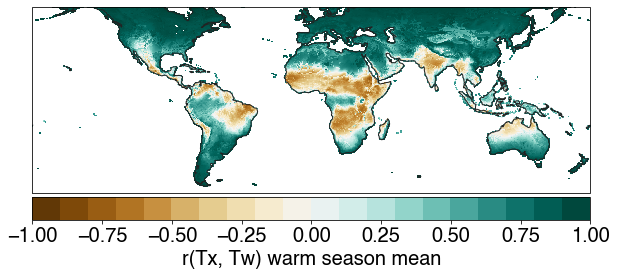

In [99]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean.tx_tw_corr

masked_data = data.where(land_sea_mask_binary)

c = plt.pcolormesh(lon, lat, masked_data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season mean', fontsize=20)


# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



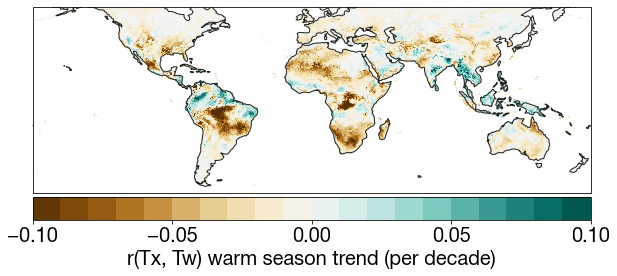

In [104]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_trend.tx_tw_corr_warm_season_trend*10
p_val = tx_tw_corr_trend.tx_tw_corr_warm_season_p_value

mask = p_val < 0.1
masked_data = data.where(mask)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw) warm season trend (per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



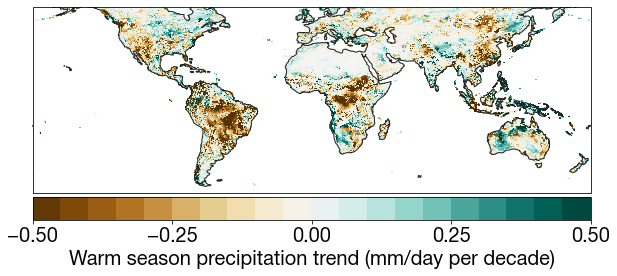

In [130]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = era5_monthly_tp_trend_max_r2*10*1000

c = plt.pcolormesh(lon, tp_on_tx_trend.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Warm season precipitation trend (mm/day per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



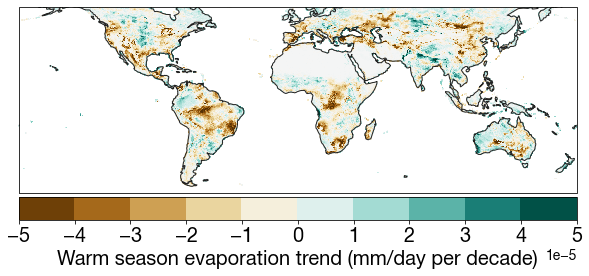

In [46]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -5e-5
v2 = 5.01e-5
vstep = 1e-5
vlabelstep = 1e-5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = evap_on_tx_trend['evaporation_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60))

c = plt.pcolormesh(lon, tp_on_tx_trend.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Warm season evaporation trend (mm/day per decade)', fontsize=20)

# plt.savefig('r(tx,tw)-trend-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)



In [51]:
tx_tw_corr_trend_1d = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.sel(latitude=slice(60,-60)).values.reshape([tx_tw_corr_trend.tx_tw_corr_warm_season_trend.sel(latitude=slice(60,-60)).values.size])*10
era5_monthly_tp_trend_max_r2_1d = era5_monthly_tp_trend_max_r2.reshape([era5_monthly_tp_trend_max_r2.size])

use_tx = True

if use_tx:
    era5_evap_trend_1d = evap_on_txx_trend['evap_on_txx_trend'].sel(latitude=slice(60,-60)).values.reshape([evap_on_txx_trend['evap_on_txx_trend'].sel(latitude=slice(60,-60)).values.size])
#     era5_evap_trend_1d = evap_on_tx_season_trend['evap_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.reshape([evap_on_tx_season_trend['evap_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.size])
    
    era5_sm_trend_1d = sm_on_tx_trends['sm_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([sm_on_tx_trends['sm_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
#     era5_huss_trend_1d = huss_on_tx_season_trend['huss_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.reshape([huss_on_tx_season_trend['huss_on_tx_season_trend'].sel(latitude=slice(60,-60)).values.size])
    era5_huss_trend_1d = huss_on_txx_trend['huss_on_txx_trend'].sel(latitude=slice(60,-60)).values.reshape([huss_on_txx_trend['huss_on_txx_trend'].sel(latitude=slice(60,-60)).values.size])
else:
#     era5_evap_trend_1d = evap_on_tw_trend['evaporation_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([evap_on_tw_trend['evaporation_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
    era5_evap_trend_1d = evap_on_tww_trend['evap_on_tww_trend'].sel(latitude=slice(60,-60)).values.reshape([evap_on_tww_trend['evap_on_tww_trend'].sel(latitude=slice(60,-60)).values.size])
    era5_sm_trend_1d = sm_on_tw_trends['sm_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([sm_on_tw_trends['sm_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
#     era5_huss_trend_1d = huss_on_tw_trend['huss_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.reshape([huss_on_tw_trend['huss_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)).values.size])
    era5_huss_trend_1d = huss_on_tww_trend['huss_on_tww_trend'].sel(latitude=slice(60,-60)).values.reshape([huss_on_tww_trend['huss_on_tww_trend'].sel(latitude=slice(60,-60)).values.size])
    

    

In [52]:
tx_tw_corr_trend_percentile_levels = np.nanpercentile(tx_tw_corr_trend_1d, np.arange(1,99))
abs_diff = np.abs(tx_tw_corr_trend_1d[:, np.newaxis] - tx_tw_corr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
tx_tw_corr_trend_percentiles_1d = min_diff_indices.astype(float)
tx_tw_corr_trend_percentiles_1d[tx_tw_corr_trend_percentiles_1d == 0] = np.nan



evap_trend_percentile_levels = np.nanpercentile(era5_evap_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_evap_trend_1d[:, np.newaxis] - evap_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
evap_trend_percentiles_1d = min_diff_indices.astype(float)
evap_trend_percentiles_1d[evap_trend_percentiles_1d == 0] = np.nan




pr_trend_percentile_levels = np.nanpercentile(era5_monthly_tp_trend_max_r2_1d, np.arange(1,99))
abs_diff = np.abs(era5_monthly_tp_trend_max_r2_1d[:, np.newaxis] - pr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
pr_trend_percentiles_1d = min_diff_indices.astype(float)
pr_trend_percentiles_1d[pr_trend_percentiles_1d == 0] = np.nan



sm_trend_percentile_levels = np.nanpercentile(era5_sm_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_sm_trend_1d[:, np.newaxis] - sm_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
sm_trend_percentiles_1d = min_diff_indices.astype(float)
sm_trend_percentiles_1d[sm_trend_percentiles_1d == 0] = np.nan




huss_trend_percentile_levels = np.nanpercentile(era5_huss_trend_1d, np.arange(1,99))
abs_diff = np.abs(era5_huss_trend_1d[:, np.newaxis] - huss_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
huss_trend_percentiles_1d = min_diff_indices.astype(float)
huss_trend_percentiles_1d[huss_trend_percentiles_1d == 0] = np.nan

In [53]:
nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(evap_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_evap = sm.OLS(evap_trend_percentiles_1d[nn],X).fit()
mdl_evap.summary()

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(huss_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_huss = sm.OLS(huss_trend_percentiles_1d[nn],X).fit()
mdl_huss.summary()

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(sm_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_sm = sm.OLS(sm_trend_percentiles_1d[nn],X).fit()
mdl_sm.summary()

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(pr_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_pr = sm.OLS(pr_trend_percentiles_1d[nn],X).fit()
mdl_pr.summary();

In [54]:
tx_tw_corr_trend_deciles_inds = {}
for i in range(10, 101, 10):
    tx_tw_corr_trend_deciles_inds[i] = np.where((tx_tw_corr_trend_percentiles_1d < i) & (tx_tw_corr_trend_percentiles_1d >= i-10))[0]

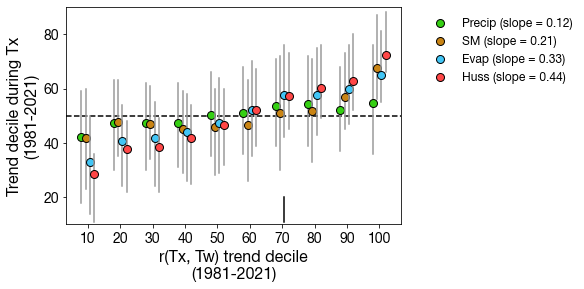

In [218]:
plt.figure(figsize=(6,4))
plt.xlim([0,31])
plt.ylim([10,90])
deciles = np.arange(10, 101, 10) 

plt.plot([0,31], [50,50], '--', color='k')

plt.plot([20.2,20.2], [11,20], '-k')

x = 2
offset=.4
for i in deciles:

 
    cur_x = x - .6
    y1 = np.nanpercentile(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x,cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1, label='Precip (slope = %.2f)'%mdl_pr.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(pr_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1)
        
    cur_x = x - .2
    y1 = np.nanpercentile(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#c98414', mew=1, label='SM (slope = %.2f)'%mdl_sm.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(sm_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#c98414', mew=1)
        
        
    cur_x = x + .2
    y1 = np.nanpercentile(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#42c5f5', mew=1, label='Evap (slope = %.2f)'%mdl_evap.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(evap_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#42c5f5', mew=1)
    
    
    cur_x = x + .6
    y1 = np.nanpercentile(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]], 67)
    
    plt.plot([cur_x, cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#ff4747', mew=1, label='Huss (slope = %.2f)'%mdl_huss.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(huss_trend_percentiles_1d[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#ff4747', mew=1)
    
    
    x+=3


    
plt.xticks(np.arange(2,31,3))
plt.gca().set_xticklabels(deciles)
plt.xlabel('r(Tx, Tw) trend decile\n(1981-2021)')

if use_tx:
    plt.ylabel('Trend decile during Tx\n(1981-2021)')
else:
    plt.ylabel('Trend decile during Tw\n(1981-2021)')

plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')

# if use_tx:
#     plt.savefig('r(tx,tw)-pct-chg-vs-huss-evap-pr-sm-pct-on-tx-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
# else:
#     plt.savefig('r(tx,tw)-pct-chg-vs-huss-evap-pr-sm-pct-on-tw-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

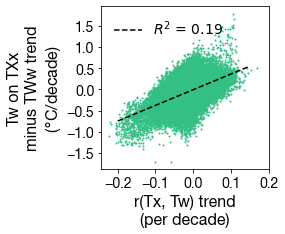

In [57]:


v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tw_on_txx_minus_tw_on_tww_trend.tw_on_txx_minus_tw_on_tww_trend.values.reshape([tw_on_txx_minus_tw_on_tww_trend.tw_on_txx_minus_tw_on_tww_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1.5, -1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tw on TXx\nminus TWw trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tw_on_txx_minus_tw_on_tww-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

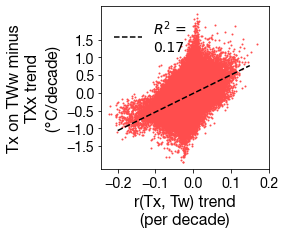

In [58]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tx_on_tww_minus_tx_on_txx_trend.tx_on_tww_minus_tx_on_txx_trend.values.reshape([tx_on_tww_minus_tx_on_txx_trend.tx_on_tww_minus_tx_on_txx_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ff4d4d', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ =\n%.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1.5, -1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tx on TWw minus\nTXx trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tx_on_tww_minus_tx_on_txx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

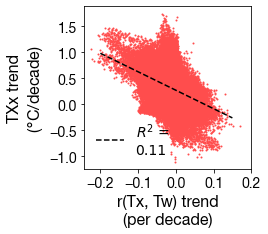

In [59]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tx_on_txx_trend.tx_on_txx_trend.values.reshape([tx_on_txx_trend.tx_on_txx_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ff4d4d', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ =\n%.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, -.5, 0, .5, 1, 1.5])
plt.xticks([-.2, -.1, 0, .1, 0.2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('TXx trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tw_on_tx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

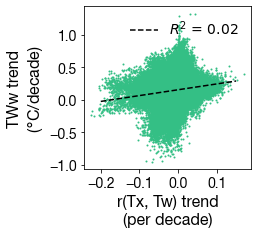

In [60]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tw_on_tww_trend.tw_on_tww_trend.values.reshape([tw_on_tww_trend.tw_on_tww_trend.values.size]) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, -.5, 0, .5, 1])
plt.xticks([-.2, -.1, 0, .1])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('TWw trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tww-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

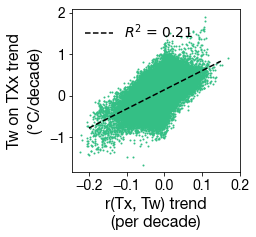

In [61]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tw_on_txx_trend.tw_on_txx_trend.values.reshape(tw_on_txx_trend.tw_on_txx_trend.values.size) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#34bf85', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.yticks([-1, 0, 1, 2])
plt.xticks([-.2, -.1, 0, .1, .2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tw on TXx trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tw_on_txx-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

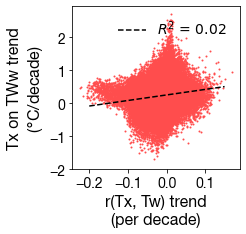

In [62]:
v1 = tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.reshape(tx_tw_corr_trend.tx_tw_corr_warm_season_trend.values.size) * 10
v2 = tx_on_tww_trend.tx_on_tww_trend.values.reshape(tx_on_tww_trend.tx_on_tww_trend.values.size) * 10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.2
x2 = .15

plt.figure(figsize=(3,3))
plt.scatter(v1, v2, c='#ff4d4d', s=1)
plt.plot([x1, x2], [mdl.params[0] + mdl.params[1]*x1, mdl.params[0] + mdl.params[1]*x2], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)
plt.xticks([-.2, -.1, 0, .1])
plt.yticks([-2, -1, 0, 1, 2])
plt.xlabel('r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Tx on TWw trend\n($\degree$C/decade)')
plt.savefig('r(tx,tw)-vs-tx_on_tww-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)